In [2]:
# Importing Libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel
from sklearn.metrics import mean_squared_error, r2_score

# Loading Data
file_path = 'H:\\database.csv'  
df = pd.read_csv(file_path)

# Selecting Features and Target
features = ['Depth', 'Percussion pressure', 'Feed pressure', 'Rotation pressure', 'Dampening pressure', 'Hardness']
target = 'Penetration rate'

# Splitting Data
X = df[features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardizing Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Simplifying the kernel
kernel = RBF()

# Instantiating the GaussianProcessRegressor with the simplified kernel and added regularization
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=1e-3)

# Using a smaller subset of the data for testing
subset_size = int(0.1 * X_train_scaled.shape[0])
X_train_subset = X_train_scaled[:subset_size]
y_train_subset = y_train[:subset_size]

# Training the model on the subset of the scaled training data
gpr.fit(X_train_subset, y_train_subset)


# Predictions and Evaluation
y_pred = gpr.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')


Mean Squared Error: 0.2883703062684629
R-squared: 0.312006824752205


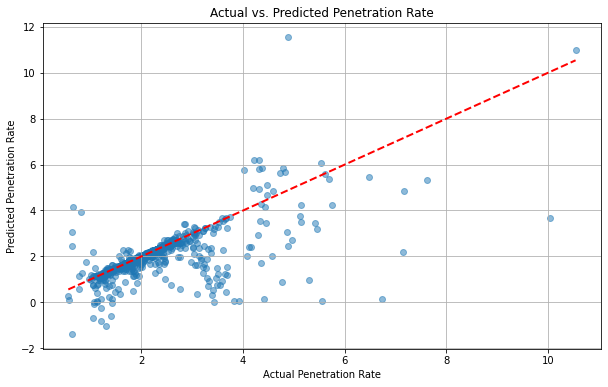

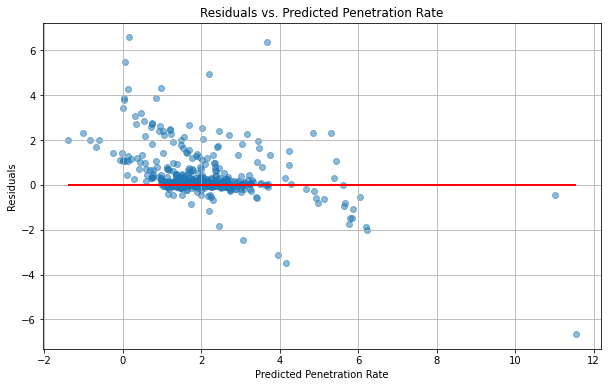

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Predictions for the entire test set
y_pred_full = gpr.predict(X_test_scaled)

# Actual vs Predicted Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_full, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--r', linewidth=2)
plt.xlabel('Actual Penetration Rate')
plt.ylabel('Predicted Penetration Rate')
plt.title('Actual vs. Predicted Penetration Rate')
plt.grid(True)
plt.show()

# Residuals Plot
residuals = y_test - y_pred_full
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_full, residuals, alpha=0.5)
plt.hlines(0, min(y_pred_full), max(y_pred_full), colors='r', linewidth=2)
plt.xlabel('Predicted Penetration Rate')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Penetration Rate')
plt.grid(True)
plt.show()


# Feature Engineering

## A. Log Transformation Code:

In [4]:
import numpy as np

# List of features to log-transform
log_features = ['Percussion pressure', 'Feed pressure', 'Rotation pressure', 'Penetration rate']

# Apply log transformation
for feature in log_features:
    df[feature] = np.log1p(df[feature])

## B. Interaction Term Creation Code:

In [5]:
# Interaction between Depth and Percussion pressure
df['Depth_Percussion'] = df['Depth'] * df['Percussion pressure']

# Interaction between Feed pressure and Rotation pressure
df['Feed_Rotation'] = df['Feed pressure'] * df['Rotation pressure']

# Model Optimization with Transformed Features

## A. Data Splitting:

In [6]:
# Add the new interaction terms to the feature set
extended_features = features + ['Depth_Percussion', 'Feed_Rotation']

# Splitting the data
X = df[extended_features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## B. Standardizing the Features:

In [7]:
# Scaling the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## C. Model Training:

In [8]:
# Using the RBF kernel
kernel = RBF()

# Instantiating the GaussianProcessRegressor
gpr_transformed = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=1e-3)

# Training the model
gpr_transformed.fit(X_train_scaled, y_train)

GaussianProcessRegressor(alpha=0.001, kernel=RBF(length_scale=1),
                         n_restarts_optimizer=10)

## D. Model Evaluation:

In [9]:
# Making predictions
y_pred_transformed = gpr_transformed.predict(X_test_scaled)

# Calculating MSE and R^2
mse_transformed = mean_squared_error(y_test, y_pred_transformed)
r2_transformed = r2_score(y_test, y_pred_transformed)

print(f'Mean Squared Error (Transformed Features): {mse_transformed}')
print(f'R-squared (Transformed Features): {r2_transformed}')

Mean Squared Error (Transformed Features): 0.0075555842747497
R-squared (Transformed Features): 0.7405709467521029


# Feature Engineering 2

## Residual Analysis

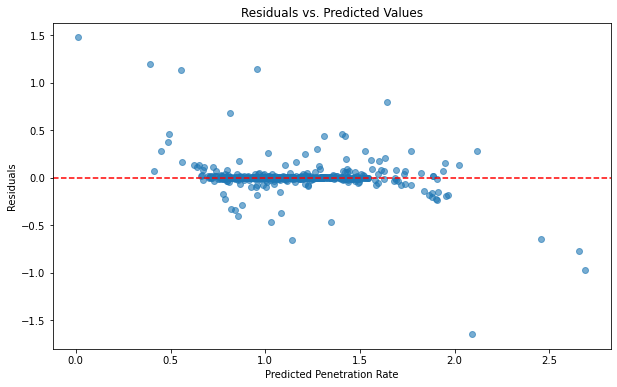

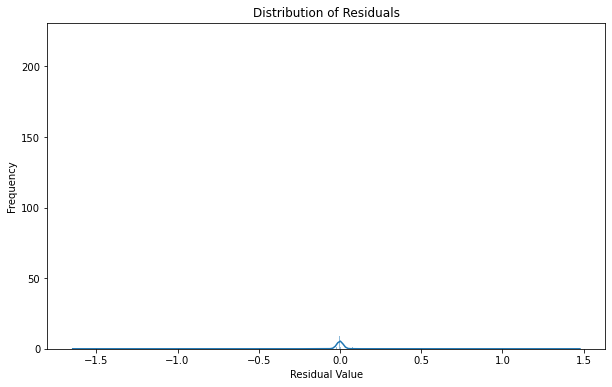

In [13]:
import seaborn as sns

# Calculate residuals
residuals = y_test - y_pred_transformed

# Plot residuals
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_transformed, residuals, alpha=0.6)
plt.axhline(0, color='r', linestyle='--')
plt.title('Residuals vs. Predicted Values')
plt.xlabel('Predicted Penetration Rate')
plt.ylabel('Residuals')
plt.show()

# Histogram of residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.title('Distribution of Residuals')
plt.xlabel('Residual Value')
plt.ylabel('Frequency')
plt.show()

## Polynomial Feature Generation

In [16]:
from sklearn.preprocessing import PolynomialFeatures

# Create polynomial features
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
X_poly = poly.fit_transform(df[extended_features])

# Convert to DataFrame for easier handling
df_poly = pd.DataFrame(X_poly, columns=poly.get_feature_names(extended_features))

## Checking for Multicollinearity

In [18]:
import warnings
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Suppress the specific RuntimeWarning
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    # Calculate VIF for each feature in the polynomial dataset
    vif_data = pd.DataFrame()
    vif_data["Feature"] = df_poly.columns

    # Compute VIF values
    vif_values = []
    for i in range(df_poly.shape[1]):
        try:
            vif = variance_inflation_factor(df_poly.values, i)
            vif_values.append(vif)
        except:
            vif_values.append(float('inf'))

    vif_data["VIF"] = vif_values

    # Display features with high VIF values (including those with infinite VIF)
    high_vif_features = vif_data[vif_data["VIF"] > 10]
    print(high_vif_features)

                                   Feature           VIF
0                                    Depth  3.522802e+08
1                      Percussion pressure  8.049114e+08
2                            Feed pressure  1.492944e+09
3                        Rotation pressure  3.242033e+08
4                       Dampening pressure  1.286603e+08
5                                 Hardness  7.147193e+05
6                         Depth_Percussion           inf
7                            Feed_Rotation           inf
8                                  Depth^2  2.099750e+07
9                Depth Percussion pressure           inf
10                     Depth Feed pressure  5.699490e+08
11                 Depth Rotation pressure  3.646226e+08
12                Depth Dampening pressure  4.367899e+06
13                          Depth Hardness  3.912711e+04
14                  Depth Depth_Percussion  9.020548e+07
15                     Depth Feed_Rotation  7.006993e+08
16                   Percussion

## Eliminate Multicollinear Features

In [19]:
# Features to remove
features_to_remove = high_vif_features[high_vif_features['VIF'] > 1e8]['Feature'].tolist()

# Updated dataframe
df_poly_reduced = df_poly.drop(columns=features_to_remove)

## Model Retraining and Evaluation

In [20]:
# Splitting the data
X_reduced = df_poly_reduced
y = df[target]
X_train_red, X_test_red, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

# Scaling
scaler_red = StandardScaler()
X_train_scaled_red = scaler_red.fit_transform(X_train_red)
X_test_scaled_red = scaler_red.transform(X_test_red)

# Model training
gpr_reduced = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=1e-3)
gpr_reduced.fit(X_train_scaled_red, y_train)

# Evaluation
y_pred_reduced = gpr_reduced.predict(X_test_scaled_red)
mse_reduced = mean_squared_error(y_test, y_pred_reduced)
r2_reduced = r2_score(y_test, y_pred_reduced)

print(f'Mean Squared Error (Reduced Features): {mse_reduced}')
print(f'R-squared (Reduced Features): {r2_reduced}')

Mean Squared Error (Reduced Features): 0.006411391835614595
R-squared (Reduced Features): 0.7798580158157401


## visualize the feature importances

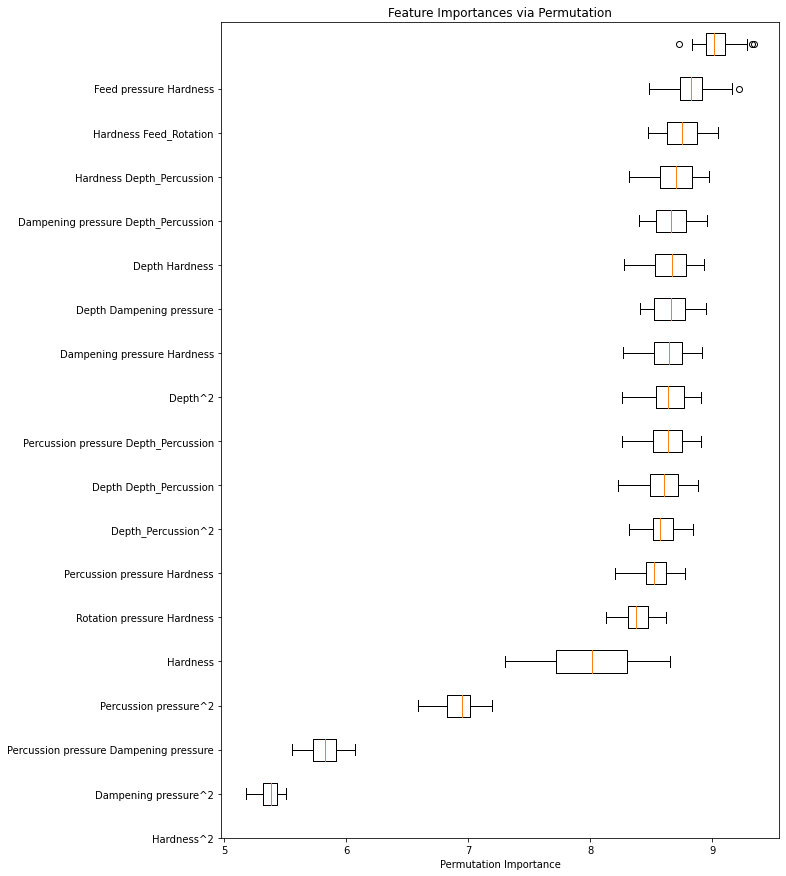

In [21]:
from sklearn.inspection import permutation_importance

# Compute permutation importance
perm_importance = permutation_importance(gpr_reduced, X_test_scaled_red, y_test, n_repeats=30, random_state=42)

# Extract importances and their indices
sorted_idx = perm_importance.importances_mean.argsort()

# Plotting
plt.figure(figsize=(10, 15))
plt.boxplot(perm_importance.importances[sorted_idx].T, vert=False)
plt.yticks(range(len(sorted_idx)), np.array(df_poly_reduced.columns)[sorted_idx])
plt.xlabel('Permutation Importance')
plt.title('Feature Importances via Permutation')
plt.show()

## Model with Top Features:

In [23]:
# Selecting top features
top_features = [
    'Feed pressure Hardness', 'Hardness Feed_Rotation', 'Hardness Depth_Percussion', 
    'Dampening pressure Depth_Percussion', 'Depth Hardness', 'Depth Dampening pressure', 
    'Dampening pressure Hardness', 'Depth^2', 'Percussion pressure Depth_Percussion', 
    'Depth Depth_Percussion'
]

# Splitting the data with top features
X_top = df_poly_reduced[top_features]
X_train_top, X_test_top, y_train, y_test = train_test_split(X_top, y, test_size=0.2, random_state=42)

# Scaling
scaler_top = StandardScaler()
X_train_scaled_top = scaler_top.fit_transform(X_train_top)
X_test_scaled_top = scaler_top.transform(X_test_top)

# Model training
gpr_top = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=1e-3)
gpr_top.fit(X_train_scaled_top, y_train)

# Evaluation
y_pred_top = gpr_top.predict(X_test_scaled_top)
mse_top = mean_squared_error(y_test, y_pred_top)
r2_top = r2_score(y_test, y_pred_top)

print(f'Mean Squared Error (Top Features): {mse_top}')
print(f'R-squared (Top Features): {r2_top}')

Mean Squared Error (Top Features): 0.005108264937414426
R-squared (Top Features): 0.8246022692273187


## Residual Analysis

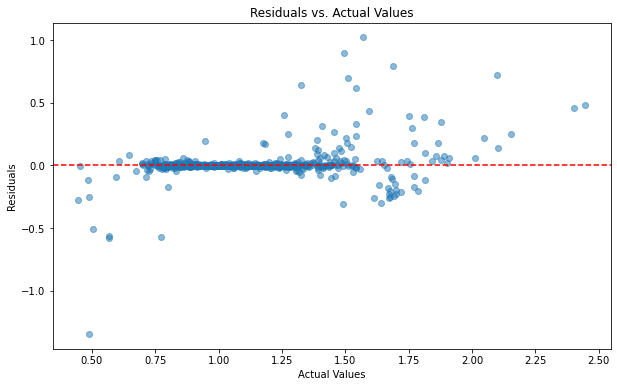

In [24]:
# Calculate residuals
residuals_top = y_test - y_pred_top

# Plotting residuals
plt.figure(figsize=(10, 6))
plt.scatter(y_test, residuals_top, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Actual Values')
plt.show()

### Penetration rate

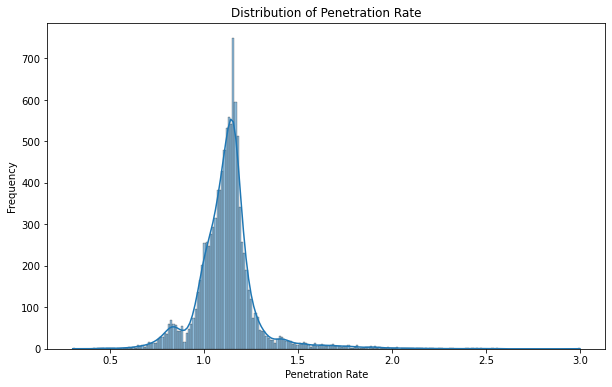

In [25]:
# Plotting the distribution of the target variable
plt.figure(figsize=(10, 6))
sns.histplot(df['Penetration rate'], kde=True)
plt.title('Distribution of Penetration Rate')
plt.xlabel('Penetration Rate')
plt.ylabel('Frequency')
plt.show()